# Initialization

In [8]:
%load_ext autoreload
%autoreload 2
%pylab nbagg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [9]:
import sys
import os
import tigre
from scipy.signal import fftconvolve

sys.path.insert(0,'../xpecgen')

import xpecgen as xg

In [10]:
phantom = np.load(os.path.join(xg.data_path,'phantoms/catphan_low_contrast_256.npy'))
# phantom = np.tile(phantom,[2,2,2])

In [11]:
det = 'CWO'
spectrum_file = 'Al_spectrum_6'

angles = np.linspace(0,2*np.pi,90)

In [12]:
s = xg.Spectrum()

energies = []
fluence = []

with open(os.path.join(xg.data_path, "MV_spectra", f'{spectrum_file}.txt')) as f:
    for line in f:
        energies.append(float(line.split()[0]))
        fluence.append(float(line.split()[1]))

# Check if MV

s.x = np.array(energies)*1000  # to keV
s.y = np.array(fluence)

In [29]:
original_energies_keV = np.array([30, 40, 50 ,60, 70, 80 ,90 ,100 ,300 ,500 ,700, 900, 1000 ,2000 ,4000 ,6000])

large_energies = np.linspace(0,6000,6001)/1000
fluence_large = np.interp(large_energies,np.array(energies), fluence)

fluence_small = np.zeros(len(original_energies_keV))

for ii, val in enumerate(large_energies):
    
    index = np.argmin(np.abs(original_energies_keV-val*1000))
    fluence_small[index] += fluence_large[ii] 

<IPython.core.display.Javascript object>


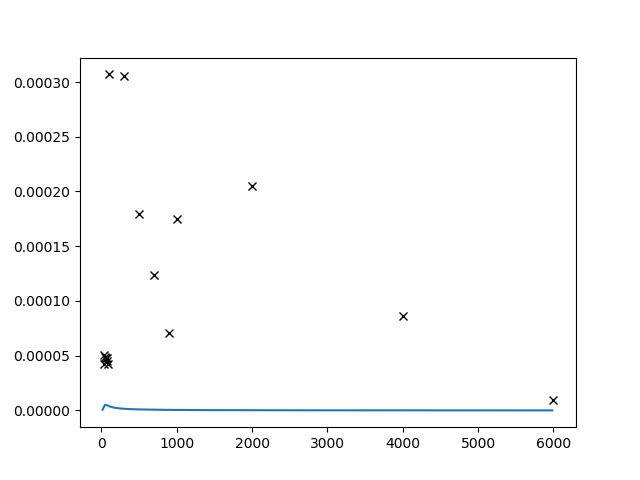

In [31]:
plt.figure()
plt.plot(original_energies_keV,fluence_small,'kx')
plt.plot(1000*np.array(energies),fluence)

In [53]:
os.path.join(xg.data_path, "MV_spectra", f'{spectrum_file}.txt')

'/home/xcite/xpecgen/xpecgen/data/MV_spectra/Al_spectrum_6.txt'

In [54]:
# from glob import glob

# files = sorted(glob(dump_files))

# plt.figure()
# plt.imshow(np.load('/home/xcite/topas/scintillators/Cu-GOS/runs/analysis/2020-06-03-h14m33/PhotodiodeSurface_keV_0030.phsp.npy'))

In [55]:
dump_files = os.path.join(
    xg.data_path, "Detectors", det, '*phsp.npy')
energy_deposition_file = os.path.join(
    xg.data_path, "Detectors", det, 'EnergyDeposition.npy')

kernel, kernels = xg.get_kernel(
                        s, dump_files, energy_deposition_file)

energy_deposition_file = os.path.join(
    xg.data_path, "Detectors", det, 'EnergyDeposition.npy')

energies = s.x
fluence = s.y
deposition_efficiency_file = energy_deposition_file

(17,) (17,)


In [32]:
deposition_summed = np.load(os.path.join(
                    xg.data_path, "Detectors", 'CWO', 'EnergyDeposition.npy'),allow_pickle=True)

In [34]:
deposition_summed[0].shape

(15,)

### Little aside for interpolating

In [10]:
from scipy.interpolate import interp2d, RectBivariateSpline

In [11]:
x = np.arange(kernel.kernel.shape[0])
y = np.arange(kernel.kernel.shape[1])

In [12]:
new_kernel = []

xx, yy = np.meshgrid(x,y)

In [13]:
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

xnew = np.arange(0.25,x[-1]+0.25,0.5)
ynew = np.arange(0.25,x[-1]+0.25,0.5)

new_kernels = []

for ii in range(kernels.shape[0]):
    
    f = RectBivariateSpline(x,y,kernels[ii],kx=1,ky=1)
    rescaled = f(xnew,ynew)
    
    new_kernel.append(np.pad(rebin(rescaled[2:-2,2:-2],[39,39]),((6,5),(6,5))))

ValueError: cannot reshape array of size 8836 into shape (39,2,39,2)

<IPython.core.display.Javascript object>


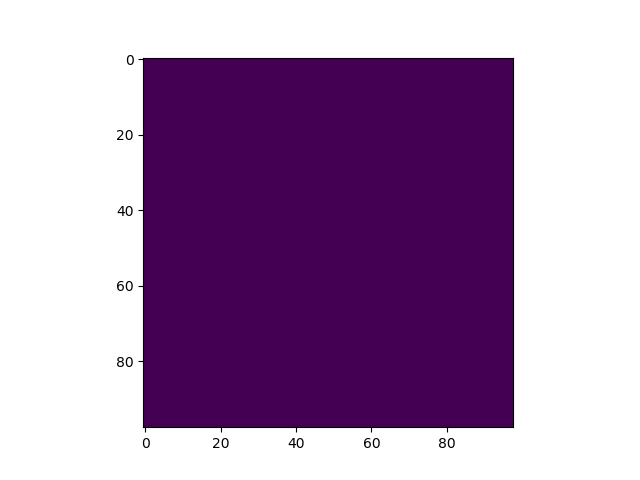

<IPython.core.display.Javascript object>


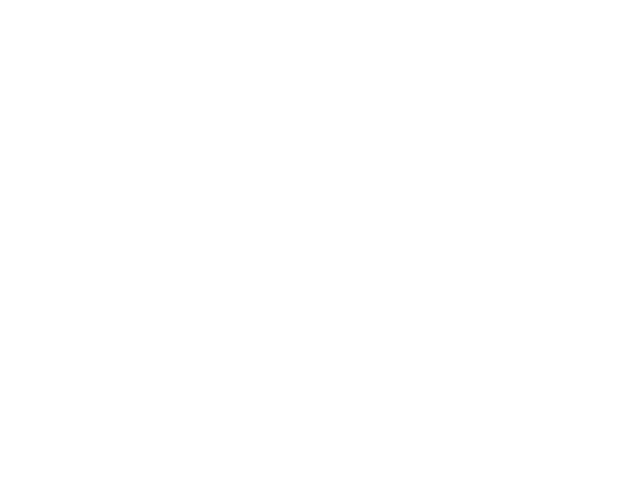

IndexError: list index out of range

In [14]:
plt.figure()
plt.imshow(rescaled) #rebin(rescaled[2:-2,2:-2],[39,39]))

plt.figure()
plt.imshow(new_kernel[-1])

plt.figure()
plt.imshow(kernels[ii])

### Now lets look at the mtf

<IPython.core.display.Javascript object>


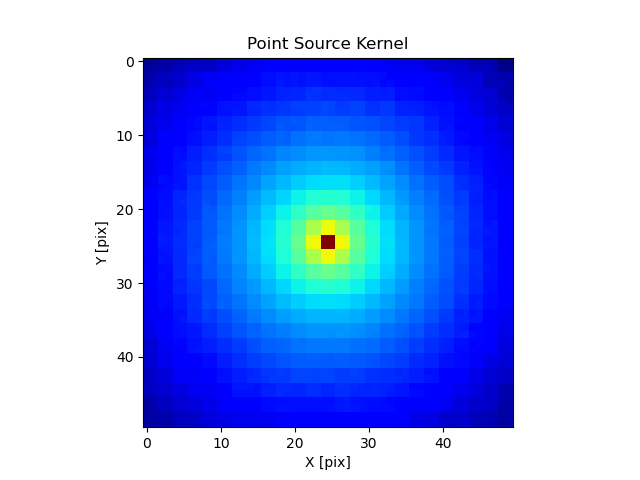

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)

kernel.get_plot(ax)

<IPython.core.display.Javascript object>


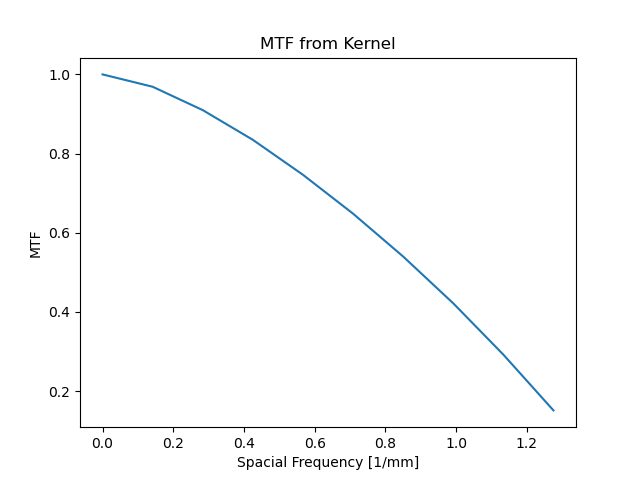

<IPython.core.display.Javascript object>


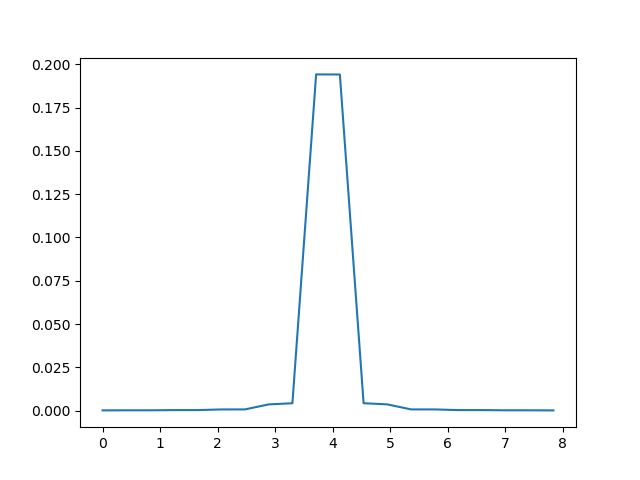

In [16]:
kernel = kernel.kernel

center = int(kernel.shape[0]/2)
lsf = kernel[center,center-10:center+10]

N = len(lsf)

if N < 10:
    T = 0.784
else:
    T = 0.392

xf = np.linspace(0.0, 1/(2.0*T), int(N/2))

mtf = np.absolute(np.fft.fft(lsf))
mtf_final = np.fft.fftshift(mtf)

fig, ax = plt.subplots()

ax.plot(xf,mtf_final[10:]/mtf_final[10])
ax.set_title('MTF from Kernel')
ax.set_xlabel('Spacial Frequency [1/mm]')
ax.set_ylabel('MTF')


plt.figure()
plt.plot(np.linspace(0,len(lsf)*0.392,len(lsf)),lsf)

In [17]:
import scipy

In [18]:
xq = np.linspace(1,7,100),

fq = scipy.interpolate.interp1d(np.linspace(0,len(lsf)*0.392,len(lsf)),lsf,kind='cubic')

yq = fq(xq)

<IPython.core.display.Javascript object>


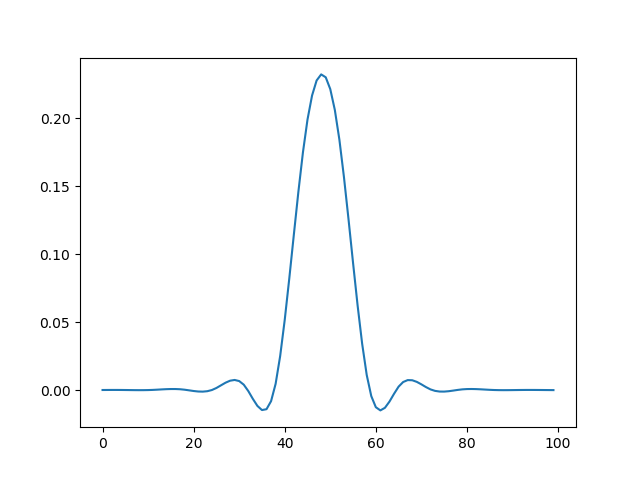

In [19]:
plt.figure()
plt.plot(yq.squeeze())

<IPython.core.display.Javascript object>


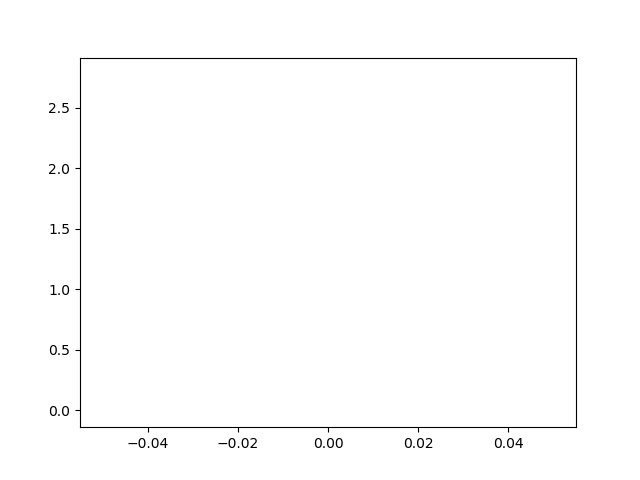

In [20]:
mtf = np.absolute(np.fft.fft(yq))
mtf_final = np.fft.fftshift(mtf)

plt.figure()
plt.plot(mtf_final)

In [21]:
len(lsf)

20

In [22]:
new_kernel = np.array(new_kernel)

<IPython.core.display.Javascript object>


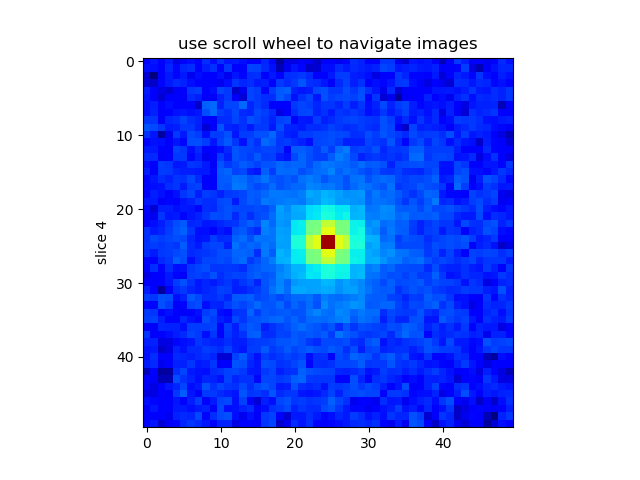

In [23]:
from matplotlib import cm
from matplotlib.colors import LogNorm

class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        rows, cols, self.slices = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[:, :, self.ind], cmap=cm.jet, norm=LogNorm())
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()


fig, ax = plt.subplots(1, 1)

X = np.array(kernels)

tracker = IndexTracker(ax, X.T)


fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

In [24]:
kernels.shape

(17, 50, 50)

### Lets finish what we started

In [56]:
# phantom_mapping = ['air','water','bone','brain','bone']
phantom_mapping = ['air','water','water','water','water','water','water','water','water']

# Don't want to look for zeros
useful_phantom = phantom != 0

original_energies_keV = np.array([30, 40, 50 ,60, 70, 80 ,90 ,100 ,300 ,500 ,700, 900, 1000 ,2000 ,4000 ,6000])

deposition_summed = np.array([    0.        ,  2395.25927928,  3434.7986552 ,  4416.62822646,
    5373.00952021,  6067.40938147,  6955.18365258,  7901.50699458,
    8860.76810654, 20457.403665  , 22916.6726841 , 26069.46417263,
   29726.25290966, 31589.13314065, 49335.93687135])

masks = np.zeros([len(phantom_mapping)-1,useful_phantom.shape[0],useful_phantom.shape[1],useful_phantom.shape[2]])
mapping_functions = []

# Get the mapping functions for the different tissues
for ii in range(1,len(phantom_mapping)):

    mapping_functions.append(xg.get_mu(phantom_mapping[ii])) # density of water
    masks[ii-1] = phantom == ii

geo = tigre.geometry_default(high_quality=False,nVoxel=phantom.shape)
geo.DSD = 1500
geo.nDetector = np.array([64,512])
geo.dDetector = np.array([0.672, 0.672])
geo.sDetector = geo.dDetector * geo.nDetector

geo.accuracy = 0.1
geo.sVoxel = np.array((160, 160, 160)) 
geo.dVoxel = geo.sVoxel/geo.nVoxel 
# angles = np.linspace(0, 0, 1, dtype=np.float32)

energy = 100

phantom2 = phantom.copy().astype(np.float32)

In [57]:
%%time

proj = []

for energy in original_energies_keV[1:]:
    for ii in range(0,len(phantom_mapping)-1):

        phantom2[masks[ii].astype(bool)] = mapping_functions[ii](energy)*.997

    proj.append(np.squeeze(tigre.Ax(phantom2,geo,angles)))

proj_filt = proj.copy()

CPU times: user 3.11 s, sys: 707 ms, total: 3.82 s
Wall time: 3.92 s


In [58]:
out = []

fluence_small = np.interp(original_energies_keV[1:],np.array(energies), fluence)

weights_small = fluence_small*deposition_summed

weights_small /= np.sum(weights_small)
    
for kk in range(len(angles)):
    for ii in range(len(original_energies_keV)-1):
        
        sum_kern = np.sum(kernels[ii+1])
        
        if sum_kern > 0:

            proj_filt[ii] = fftconvolve(proj[ii][kk],kernels[ii+1]/sum_kern, mode = 'same')
            
        else:
            
            proj_filt[ii] = np.zeros(proj_filt[ii].shape)
                                    
    out.append(np.array(proj_filt).T@weights_small)

<IPython.core.display.Javascript object>


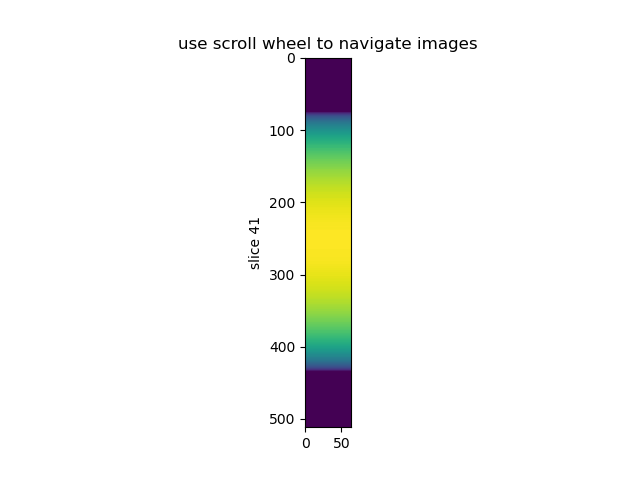

In [60]:

class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        rows, cols, self.slices = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[:, :, self.ind])
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()


fig, ax = plt.subplots(1, 1)

X = np.array(proj[0])

tracker = IndexTracker(ax, X.T)


fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

In [75]:
mapping_functions[0](40)

0.2683

<IPython.core.display.Javascript object>


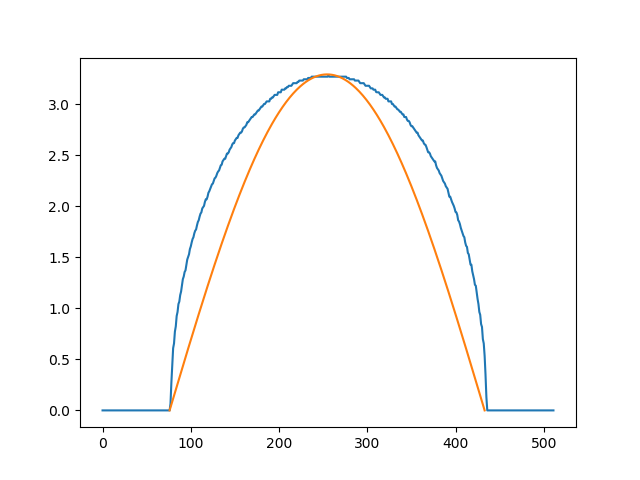

In [82]:
plt.figure()
plt.plot(np.mean(proj[2][0],0)/10)

xx = np.linspace(76,433,433-76+1)

circle = 16*mapping_functions[0](60)*np.sin(np.linspace(0,pi,433-76+1))

yy = 40*(1 - np.exp(-circle))

plt.plot(xx,circle)

In [ ]:
plt.figure()
plt.plot(np.exp(-np.mean(proj[2][0],0)/10))

plt.plot(np.exp(-))

In [ ]:
np.array(proj_filt).shape

In [ ]:
np.save('projections_water',out)

In [ ]:
np.save('projections_water_full',proj)

In [ ]:
img = tigre.algorithms.FDK(
    np.transpose(np.array(out),[0,2,1]), geo, angles)

In [ ]:

class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        rows, cols, self.slices = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[:, :, self.ind])
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()


fig, ax = plt.subplots(1, 1)

X = np.array(img)

tracker = IndexTracker(ax, X.T)


fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

# Equivalent Fastcat

In [ ]:
angles = np.linspace(0,2*pi,360)

spectrum = xg.Spectrum()

spectrum.x = energies
spectrum.y = fluence

kernel, kernels= xg.get_kernel(spectrum,dump_files,energy_deposition_file)

projs_xg = xg.return_projs(phantom,kernel,energies,fluence,angles,geo,deposition_efficiency_file=deposition_efficiency_file)

In [ ]:
img_xg = tigre.algorithms.FDK(
    np.transpose(np.array(projs_xg[0]),[0,2,1]), geo, angles)

<IPython.core.display.Javascript object>


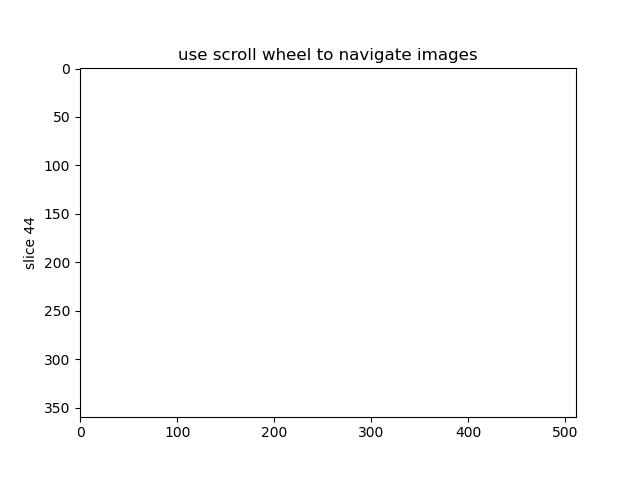

In [47]:
fig, ax = plt.subplots(1, 1)

X = np.array(projs_xg[0])

tracker = IndexTracker(ax, X)

fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

In [42]:
np.array(projs_xg)[0].shape

(360, 512, 64)

In [ ]:
xg.analyse_515(img_xg[5])

### Manual Analysis

In [ ]:
from xpecgen import *

In [ ]:
recon_slice = img_xg[5]

def create_mask():

    im = np.zeros([256,256])
    ii = 1

    # CTMAT(x) formel=H2O dichte=x
    LEN = 100

    A0  = 87.7082*np.pi/180
    A1 = 108.3346*np.pi/180
    A2 = 126.6693*np.pi/180
    A3 = 142.7121*np.pi/180
    A4 = 156.4631*np.pi/180
    A5 = 167.9223*np.pi/180
    A6 = 177.0896*np.pi/180
    A7 = 183.9651*np.pi/180
    A8 = 188.5487*np.pi/180

    B0 = 110.6265*np.pi/180
    B1 = 142.7121*np.pi/180
    B2 = 165.6304*np.pi/180
    B3 = 179.3814*np.pi/180

    # Phantom 
    # ++++ module body ++++++++++++++++++++++++++++++++++++++++++++++++++ */                        
    create_circular_mask(x= 0.000,  y= 0.000,  r=1.0, index = ii, image = im)

    ii += 1

    # ++++ supra-slice 1.0% targets +++++++++++++++++++++++++++++++++++++++ */
    create_circular_mask(x= 5*cos(A0),  y= 5*sin(A0),  r=0.75, index = ii, image = im); ii += 1
    create_circular_mask(x= 5*cos(A1),  y= 5*sin(A1),  r=0.45, index = ii, image = im); ii += 1
    create_circular_mask(x= 5*cos(A2),  y= 5*sin(A2),  r=0.40, index = ii, image = im); ii += 1
    create_circular_mask(x= 5*cos(A3),  y= 5*sin(A3),  r=0.35, index = ii, image = im); ii += 1
    create_circular_mask(x= 5*cos(A4),  y= 5*sin(A4),  r=0.30, index = ii, image = im); ii += 1
    create_circular_mask(x= 5*cos(A5),  y= 5*sin(A5),  r=0.25, index = ii, image = im); ii += 1
    create_circular_mask(x= 5*cos(A6),  y= 5*sin(A6),  r=0.20, index = ii, image = im); ii += 1
    create_circular_mask(x= 5*cos(A7),  y= 5*sin(A7),  r=0.15, index = ii, image = im); ii += 1
    create_circular_mask(x= 5*cos(A8),  y= 5*sin(A8),  r=0.10, index = ii, image = im); ii += 1

    return im

def create_mask_multi():

    im = np.zeros([256,256])
    ii = 1

    # CTMAT(x) formel=H2O dichte=x
    LEN = 100

    A0  = 87.7082*np.pi/180
    A1 = 108.3346*np.pi/180
    A2 = 126.6693*np.pi/180
    A3 = 142.7121*np.pi/180
    A4 = 156.4631*np.pi/180
    A5 = 167.9223*np.pi/180
    A6 = 177.0896*np.pi/180
    A7 = 183.9651*np.pi/180
    A8 = 188.5487*np.pi/180

    B0 = 110.6265*np.pi/180
    B1 = 142.7121*np.pi/180
    B2 = 165.6304*np.pi/180
    B3 = 179.3814*np.pi/180

    # Phantom 
    # ++++ module body ++++++++++++++++++++++++++++++++++++++++++++++++++ */                        
    create_circular_mask(x= 0.000,  y= 0.000,  r=1.0, index = ii, image = im)

    ii += 1

    # ++++ supra-slice 1.0% targets +++++++++++++++++++++++++++++++++++++++ */
    create_circular_mask(x= 2.5*cos(B0),  y= 2.5*sin(B0),  r=0.45, index = ii, image = im); ii += 1
    create_circular_mask(x= 2.5*cos(B0+2/3*np.pi) ,y= 2.5*sin(B0+2/3*np.pi),  r=0.45  , index = ii, image = im); ii += 1
    create_circular_mask(x= 2.5*cos(B0+4/3*np.pi) ,y= 2.5*sin(B0+4/3*np.pi),  r=0.45  , index = ii, image = im); ii += 1

    create_circular_mask(x= 5*cos(A0+4/3*np.pi),  y= 5*sin(A0+4/3*np.pi),  r=0.75, index = ii, image = im); ii += 1
    create_circular_mask(x= 5*cos(A0),  y= 5*sin(A0),  r=0.75, index = ii, image = im); ii += 1
    create_circular_mask(x= 5*cos(A0+2/3*np.pi),  y= 5*sin(A0+2/3*np.pi),  r=0.75, index = ii, image = im); ii += 1

    return im

def create_circular_mask(x, y, r, index, image):

    h,w = image.shape

    center = [x*int(w/2)/10 + int(w/2),y*int(h/2)/10 + int(h/2)]

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if r is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= r*int(w/2)/10


    image[mask] = index

im = create_mask_multi()

plt.figure()
plt.imshow(im)

plt.figure()
plt.imshow(img_xg[5])

contrast = []
noise = []
cnr = []

ii = 1

ref_mean = np.mean(recon_slice[im == ii])
ref_std = np.std(recon_slice[im == ii])

for ii in range(2,11):

    contrast.append(np.abs(np.mean(recon_slice[im == ii])- ref_mean))
    noise.append(np.std(recon_slice[im == ii]))

    cnr.append(contrast[-1]/(np.sqrt(noise[-1]**2 + ref_std**2)))

rs = np.linspace(0.1,0.45,8)

print(contrast)

In [ ]:
recon = np.load('../xpecgen/data/projs/low_contrast_recon.npy')

In [ ]:
img_xg.shape

In [2]:
noises = np.load('./noise_kernel_int.npy')

<IPython.core.display.Javascript object>


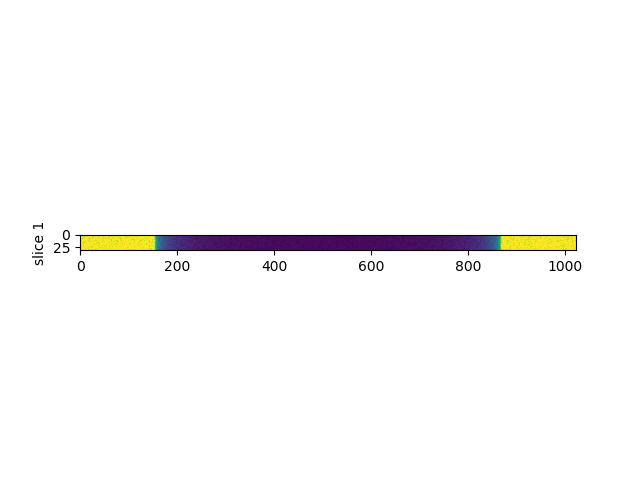

In [3]:
class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax; self.X = X
        rows, cols, self.slices = X.shape
        self.ind = self.slices//2
        self.im = ax.imshow(self.X[:, :, self.ind])
        self.update()
    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()
    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()
        
fig, ax = plt.subplots(1, 1)

X = np.sum(noises,3).T

tracker = IndexTracker(ax, X)

fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

In [4]:
noises.shape

(16, 1024, 32, 53)

In [7]:
noises_512 = (noises[:,::2,:,:] + noises[:,1::2,:,:])/2

noise_512_64 = np.tile(noises_512,[1,1,2,1])

noise_512_64[0] = noise_512_64[1]

print(noise_512_64.shape)

np.save('noise_projections',noise_512_64)

(16, 512, 64, 53)


In [ ]:
noise_512_64_15.transpose([1.shape

In [ ]:
fig, ax = plt.subplots(1, 1)

X = np.array(proj)[0,:,:,:].T

tracker = IndexTracker(ax, X)

fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

In [ ]:
np.array(proj).shape

### energies projections x y vs energies x y energies

# Need to use spectrum to weight the different spectra and sum to get the scatter as a function of energy 

# The scatter was normalized to the number of particles already

Can just multiply through with the normalized spectra

In [ ]:
energies

In [ ]:
original_energies_keV.shape

In [ ]:
fluence